In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from dr_path import settings
from dr_path.db import io, models
from dr_path.loadshape.precalculated_features import hourly_shift_potential
from dr_path.loadshape.utils import create_cal_data
%matplotlib inline

## Connect to database

In [2]:
db_file = os.path.join(settings.OUTPUT_DIR, settings.DB_NAME)
print(db_file)
#Close the DB if it's open
try:
    models.database.close()
except:
    pass
models.database.init(db_file)
models.database.connect()
print('Database contains {} demand scenarios.'.format(models.DemandScenario.select().count()))

/mnt/sdb/bgerke_cache/bto_ee_dr_cache/dr_path_inputs_resstock_comstock_2012/NENG/dr_path_NENG.db
Database contains 6 demand scenarios.


## Set up scenario parameters

In [3]:
tou_name = 'none' #'high'
tech_name = 'BAU'
weather='2012AMY'
ds_name = 'BaseDemand_ControlsOnly_2012AMY'
year=2040
dr_type='shift'
cost_frame = 'gross'

outsubdir = 'all_eligible_upgrades_20210827/{r}'.format(r=settings.REGION)
outdir = '/mnt/sdb/bgerke_cache/bto_ee_dr_cache/reeds_outputs/'+outsubdir
#end_uses = {'res':
#               ['water_heating', 'cooling', 'heating', 'pool_pump', 'refrigeration','lighting', 
#                'dishwasher', 'clothes_washer', 'clothes_dryer'],
#           'com':
#               ['water_heating', 'cooling', 'heating', 'lighting', 'interior_equipment']}

price_list = [50.,100.,150., 200.,300.,400.,500.]

ds = models.DemandScenario.get(name=ds_name)
tou = models.TOUImpactScenario.get(name=tou_name)
rs = models.RenewableScenario.get(id=1)#name='phase2', weather=ds.weather)
ts = models.TechnologyScenario.get(name=tech_name)


sup = io.get_supply_curve(ds, tou, rs, ts, 
                          year=year, dr_type='shift', timescale='year', 
                          disaggregate_by=['sector', 'end_use'], 
                          exclude={'end_use':'battery', })


### Define useful functions

In [4]:
def sum_max_two(x):
    return np.sort(x)[-2:].sum()

def calculate_responsive_load_8760(clusters,ds,tou,rs,ts,price,end_use,year,
                                   sector=None, dr_type='shed',
                                   cost_frame='gross', timescale='year', event_hours=None):
    '''
    Get an 8760 of responsive load, for a given scenario, end use, and DR type,
    and for a given set of clusters
    '''
    
    if sector:
        where = (models.SiteInstallation.sector == sector)
    else:
        where=True
    
    #Get all DR pathways that are selected at a given procurement price.
    path = io.get_pathways_df_at_price(ds, tou, rs, ts, price, 
                                    dr_type=dr_type, cost_frame=cost_frame, 
                                    end_uses=[end_use], timescale=timescale, year=year,
                                    extra_fields=[
                                        models.CLSFeature.value.alias('dr_feature'),
                                        models.SiteInstallation.end_use_customer_count],
                                      where=where)

    #downselect to a particular event duration
    if event_hours:
        path = path.loc[path['event_hours']==event_hours]
    if path is None: 
        npath=0
    else:
        npath=len(path)
    
    if npath==0:
        return None, None, None
    
    else:
        #Compute the factor by which we want to down-weight the total
        #load in each cluster load shape to represent the actual load
        #participating in Shift DR.
        path['factor'] = (path['dr_enroll_prob']*
                      path['response_factor']*
                      path['resource_factor']*
                      path['weight'])
        #Ensure it makes sense...
        try:
            assert ~(path['factor']>(path['weight'])).any()
        except:
            bad = path.loc[path['factor']>(path['weight'])]
            print('Factor bigger than expected')
            print(bad[['factor', 'dr_enroll_prob','response_factor', 
                       'resource_factor', 'td_factor','weight']])
    
        #Compute total participatation factor for each cluster load shape
        factor = path.groupby('clusterloadshape')['factor'].sum()
        
        #Get the clusters that are present in the list of pathways
        cls_sub = clusters.loc[clusters['name'].isin(path['cluster']),:]
        
        #Get their cluster load shapes for this end use.
        clshp = io.get_load_shape_df(cls_sub.index.values, eu_names=[end_use], 
                                   tou_scenario_name=tou.name)
                
        if clshp is None:
            print('Unexpectedly failed to get any loadshapes')
            print(ds.name)
            print(end_use)
            print(year)
            print(price)
            print('there were {n} pathways'.format(n=len(path)))
        #Compute the potential sheddable load from participating customers
        #and aggregate up to system levels (also have to reset column names)
        #to match
        agg_potential = clshp.mul(
            factor, level='loadshape').fillna(0).sum(axis='columns').iloc[:8760]
        
    return agg_potential, clshp, path

def calculate_shift_8760s(clusters, ds, tou, rs, ts, price, end_use, year, 
                          sector=None, 
                          cost_frame='gross', event_hours=None):
    
    agg_shift_potential, clshp, path = calculate_responsive_load_8760(
        clusters, ds,tou,rs,ts, price, end_use, year, 
        sector=sector,
        dr_type='shift', event_hours=event_hours, cost_frame=cost_frame)
    
    if agg_shift_potential is None:
        #Return blanks if there are no pathways at this price level.
        max_take_agg = None
        clshp = None
        daily_caps = None

        return max_take_agg, agg_shift_potential, daily_caps, 0, clshp

    else:
        
        #Figure out the maximum take allowed, according to the fraction
        #of customers enrolled in DR and their peak load.
        enroll_base = path.groupby('clusterloadshape')['dr_enroll_prob'].max()
        nyears = year-settings.BASE_YEAR
        enroll = (1-(1-enroll_base)*(1-ts.adopt_growth_rate)**nyears)
        
        #Compute max take for each cluster
        max_take_disagg = clshp.max()*enroll.values - clshp*enroll.values
        #Aggregate up to system level.
        max_take_agg = max_take_disagg.sum(axis='columns').iloc[:8760]
       
        #Now compute the maximum total shiftable energy per day, by looking
        #at the two largest shifts on each day.
        nls =  models.NetLoadShape.get(
                tou_scenario=tou, demand_scenario=ds, renewable_scenario=rs)
        shift_filter = pd.Series(nls.shift_filter.hourly_value).iloc[:8760]

        #Shift window for this end use at this price
        win = path['event_hours'].mul(
            path['dr_feature']).mul(
            path['weight']).sum()/ \
                path['dr_feature'].mul(
                path['weight']).sum()
    
        #Filtered shift potential for aggregate loadshape
        filtered_shift_potential, filtr = hourly_shift_potential(
            pd.DataFrame(agg_shift_potential, 
                         columns=pd.MultiIndex.from_tuples([clshp.columns[0]])), 
            shift_filter, int(round(win)),
            nls.shift_dispatch_df())
    
        shift_cal = create_cal_data().iloc[:8760]
        shift_cal['shifts'] = filtered_shift_potential.values
        shift_cal['shiftable_load'] = agg_shift_potential.values
     
        #Group by day of year and sum up the maximum available shift on each day.
        #Asssign this to an appropriate column in the output dataframe.
  
        daily_caps = shift_cal.groupby('doy')['shifts'].apply(sum_max_two)
    
        return max_take_agg, agg_shift_potential, daily_caps, win, clshp


In [5]:

def get_8760_outputs(ds, tou, rs, ts, year, outdir=None, diagnostics=True,
                     cost_frame='gross'):
    
    
    #Get supply curves
    sup_shed = io.get_supply_curve(ds, tou, rs, ts, 
                          year=year, dr_type='shed', timescale='year', 
                          disaggregate_by=['sector', 'end_use'], 
                          exclude={'end_use':'battery', })
    
    sup_shift = io.get_supply_curve(ds, tou, rs, ts, 
                          year=year, dr_type='shift', timescale='year', 
                          disaggregate_by=['sector', 'end_use'], 
                          exclude={'end_use':'battery', })
    
    #We use the supply curve as an indicator of the maximum capacity for Shift.  
    #Essentially, we are saying the max capacity for Shift is represented by
    #shedding the full amount of shiftable energy in a single hour. In nearly all cases
    #that will not be technically feasible, but the 8760 of capacity factors will account for that.
    #But if we treat the supply curve as a measure of kW of capacity, then we can say that
    # the procurement price is in $/kW-yr of capacity.

    max_capacity_shift = pd.DataFrame(sup_shift.loc[price_list].unstack(), 
                                columns=['capacity']).T
    max_capacity_shed = pd.DataFrame(sup_shed.loc[price_list].unstack(), 
                                columns=['capacity']).T
    
    #Set up data frames for output
    shift_windows = pd.Series(index=max_capacity_shift.columns).fillna(0)
    max_take_df = pd.DataFrame(columns=max_capacity_shift.columns, 
                               index=np.arange(8760)+1).fillna(0)
    shiftable_load_df = max_take_df.copy()
    daily_shift_cap_df = pd.DataFrame(columns=max_capacity_shift.columns, 
                                      index=np.arange(365)+1).fillna(0)
    sheddable_load_df = pd.DataFrame(columns=max_capacity_shed.columns, 
                                     index=np.arange(8760)+1).fillna(0)
    
    #Get relevant clusters
    clusters = io.get_cluster_df(where=((models.Cluster.year==year) & 
                                    (models.Cluster.demand_scenario == ds)))
    #Get shed outputs
    print('Extracting Shed:')
    for sec, eu, price in sheddable_load_df.columns:
        agg_shed_potential, _, _ = calculate_responsive_load_8760(
            clusters, ds, tou, rs, ts, price, eu, year, 
            dr_type='shed', cost_frame=cost_frame, sector=sec)
        
        if (agg_shed_potential is None):
            #No potential at this price; move on
            continue
            
        sheddable_load_df[(sec,eu,price)] = agg_shed_potential.values
        
        if diagnostics:
            #Diagnostic printing and plotting for 10% of examples
            if np.random.rand() > 0.9:
                print(sec, eu, price)
                fig, ax = plt.subplots(figsize=[8,3])
                agg_shed_potential.plot(ax=ax)
                plt.show()
            
    print('Extracting Shift:')
    for sec, eu, price in shiftable_load_df.columns:
        max_take_agg, agg_shift_potential, daily_caps, window, clshp2 = \
                calculate_shift_8760s(
                    clusters, ds, tou, rs, ts, price, eu, year, 
                    cost_frame=cost_frame, sector=sec)
        
        if agg_shift_potential is None:
            #No potential at this price; move on
            continue
            
        shiftable_load_df[(sec,eu,price)] = agg_shift_potential.values
        daily_shift_cap_df[(sec,eu,price)] = daily_caps.values
        shift_windows[(sec,eu,price)] = window
        max_take_df[(sec,eu,price)] = max_take_agg.values
        
        if diagnostics:
            #Diagnostic printing and plotting for 10% of examples
            if np.random.rand() > 0.9:
                print(sec, eu, price)
                fig, ax = plt.subplots(figsize=[8,3])
                agg_shift_potential.plot(ax=ax)
                max_take_agg.plot(ax=ax)
                plt.show()
            
    gls = models.GrossLoadShape.get(demand_scenario=ds, year=year)
    nls = models.NetLoadShape.get(demand_scenario=ds, year=year)
    gross_net = pd.DataFrame(
            [list(range(1,len(gls.hourly_kwh)+1)), gls.hourly_kwh, nls.hourly_kwh], 
             index=['hour_ending','gross_load','net_load']
            ).T.set_index('hour_ending')
    
    if outdir:
        sheddable_load_df.to_csv(os.path.join(outdir, 'sheddable_load.csv'))
        max_capacity_shed.to_csv(os.path.join(outdir, 'shed_capacity.csv'))
        shiftable_load_df.to_csv(os.path.join(outdir, 'shiftable_load.csv'))
        max_capacity_shift.to_csv(os.path.join(outdir, 'shift_capacity.csv'))
        daily_shift_cap_df.to_csv(os.path.join(outdir, 'shift_daily_max.csv'))
        shift_windows.to_csv(os.path.join(outdir,'shift_windows.csv'))
        max_take_df.to_csv(os.path.join(outdir,'shift_max_load_increase.csv'))
        gross_net.to_csv(os.path.join(outdir, 'gross_net_load.csv'))
                
    return (sheddable_load_df, max_capacity_shed, 
            shiftable_load_df, max_capacity_shift, daily_shift_cap_df,
            shift_windows, max_take_df, gross_net)
        

In [6]:
#Try it out for different scenarios and make sure they look different
year = 2030
scen = 'BaseDemand_EquipmentOnly_2012AMY'
(sheddable_load_df, max_capacity_shed, 
 shiftable_load_df, max_capacity_shift, daily_shift_cap_df, 
 shift_windows, max_take_df, gross_net_df)=get_8760_outputs(
    models.DemandScenario.get(name = 'BaseDemand_Baseline_2012AMY'), 
    tou, rs, ts, year, diagnostics=False)


(sheddable_load_df2, max_capacity_shed2, 
 shiftable_load_df2, max_capacity_shift2, daily_shift_cap_df2, 
 shift_windows2, max_take_df2, gross_net_df2)=get_8760_outputs(
    models.DemandScenario.get(name = scen), 
    tou, rs, ts, year, diagnostics=False)

(sheddable_load_df3, max_capacity_shed3, 
 shiftable_load_df3, max_capacity_shift3, daily_shift_cap_df3, 
 shift_windows2, max_take_df3, gross_net_df3)=get_8760_outputs(
    models.DemandScenario.get(name = scen), 
    tou, rs, ts, 2040, diagnostics=False)


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:


In [7]:
max_take_df.tail()

sector                     com                                               \
end_use                cooling                                                
procurement_price        50.0           100.0          150.0          200.0   
8756               2237.299282  117533.064563  211415.523480  195203.801800   
8757               2266.573912  117567.113175  211459.649299  195254.492274   
8758               2248.646136  117554.324109  211442.301758  195240.978088   
8759               2247.971780  117578.548305  211478.993533  195282.094880   
8760               2297.444750  117661.741669  211589.868916  195392.840593   

sector                                                                       \
end_use                                                             heating   
procurement_price          300.0          400.0         500.0         50.0    
8756               418421.743915  714149.531373  1.142782e+06  36641.999705   
8757               418479.924847  714208.096197  1.142835e+06  36536.472367   
8758               418458.717360  714177.674002  1.142812e+06  35172.089863   
8759               418506.924041  714241.594708  1.142857e+06  35866.864069   
8760               418619.467352  714354.145093  1.142970e+06  37079.066327   

sector                                          ...       res              \
end_use                                         ... pool_pump               
procurement_price          100.0         150.0  ...     300.0 400.0 500.0   
8756               929940.024522  1.837864e+06  ...         0     0     0   
8757               932446.151014  1.843563e+06  ...         0     0     0   
8758               945120.732167  1.868719e+06  ...         0     0     0   
8759               960098.946683  1.894147e+06  ...         0     0     0   
8760               971464.922640  1.922205e+06  ...         0     0     0   

sector                                                               \
end_use           water_heating                                       
procurement_price         50.0  100.0 150.0     200.0         300.0   
8756                          0     0     0  0.101866  13503.473562   
8757                          0     0     0  0.083746  16883.760529   
8758                          0     0     0  0.145624  20852.954597   
8759                          0     0     0  0.181850  23076.612233   
8760                          0     0     0  0.169153  32431.979099   

sector                                           
end_use                                          
procurement_price          400.0          500.0  
8756                83074.214454   83815.662781  
8757               107210.922339  108178.532142  
8758               131313.353157  132239.275619  
8759               142098.644970  143065.613563  
8760               195184.677765  196350.464965  

[5 rows x 56 columns]

In [8]:
sheddable_load_df.tail()

sector                    com                                        \
end_use               cooling                                         
procurement_price       50.0        100.0        150.0        200.0   
8756               183.344470  789.768756  1695.387996  2209.241639   
8757               176.462528  766.254096  1652.768599  2136.726783   
8758               176.779241  758.258194  1632.707518  2143.727983   
8759               168.203767  759.697842  1620.821311  2123.871040   
8760               151.060891  733.498911  1591.263252  2037.972354   

sector                                                                        \
end_use                                                  heating               
procurement_price        300.0        400.0        500.0   50.0  100.0 150.0   
8756               2700.585499  2706.270092  2706.270092       0     0     0   
8757               2619.724684  2624.661817  2624.661817       0     0     0   
8758               2620.181606  2625.389204  2625.389204       0     0     0   
8759               2615.280294  2621.810249  2621.810249       0     0     0   
8760               2543.851081  2550.066243  2550.066243       0     0     0   

sector             ...           res                              \
end_use            ...       cooling                               
procurement_price  ...         300.0         400.0         500.0   
8756               ...  15305.046200  15305.791864  15305.791864   
8757               ...  15808.986864  15809.742218  15809.742218   
8758               ...  16003.567109  16004.418988  16004.418988   
8759               ...  16680.872754  16681.380840  16681.380840   
8760               ...  13333.602991  13334.144500  13334.144500   

sector                                                               
end_use           water_heating                                      
procurement_price         50.0  100.0 150.0 200.0 300.0 400.0 500.0  
8756                          0     0     0     0     0     0     0  
8757                          0     0     0     0     0     0     0  
8758                          0     0     0     0     0     0     0  
8759                          0     0     0     0     0     0     0  
8760                          0     0     0     0     0     0     0  

[5 rows x 56 columns]

In [9]:
shiftable_load_df.tail()

sector                   com                                                   \
end_use              cooling                                                    
procurement_price      50.0        100.0       150.0       200.0        300.0   
8756               67.668418  470.728141  731.771723  916.776504  1293.227630   
8757               56.059734  434.654306  679.701192  862.944816  1242.928464   
8758               64.469413  458.336311  703.668324  875.824357  1252.549324   
8759               64.090809  441.605333  675.446413  838.139959  1210.004277   
8760               42.928586  359.545246  566.478445  728.369093  1099.410094   

sector                                                                   \
end_use                                          heating                  
procurement_price        400.0        500.0        50.0           100.0   
8756               1407.386592  1593.219062  3281.271140  166597.999712   
8757               1356.842444  1544.822930  3297.166291  163728.378285   
8758               1373.144409  1555.916339  3728.697972  152582.744570   
8759               1324.456133  1519.406666  3492.511876  143265.693533   
8760               1213.718191  1408.798546  3112.351421  137405.142387   

sector                            ...       res                            \
end_use                           ... pool_pump             water_heating   
procurement_price          150.0  ...     300.0 400.0 500.0         50.0    
8756               335222.752382  ...         0     0     0             0   
8757               332392.843948  ...         0     0     0             0   
8758               313393.590328  ...         0     0     0             0   
8759               296121.468974  ...         0     0     0             0   
8760               279432.597858  ...         0     0     0             0   

sector                                                                \
end_use                                                                
procurement_price 100.0 150.0     200.0         300.0          400.0   
8756                  0     0  0.162585  32020.353904  241910.593499   
8757                  0     0  0.176936  29343.166626  222794.320854   
8758                  0     0  0.127928  26199.564925  203705.195646   
8759                  0     0  0.099238  24438.428077  195163.244530   
8760                  0     0  0.109293  17028.977520  153119.106556   

sector                            
end_use                           
procurement_price          500.0  
8756               243176.932267  
8757               223881.539732  
8758               204825.430899  
8759               196250.971247  
8760               154049.368937  

[5 rows x 56 columns]

In [10]:
daily_shift_cap_df.tail()

sector                    com                                            \
end_use               cooling                                             
procurement_price       50.0          100.0         150.0         200.0   
361                938.452110  10507.476235  15612.585832  19843.846999   
362                920.142468  11468.543307  17330.981376  22307.211891   
363                885.575797  10036.411365  14952.519581  18980.588710   
364                861.162973   7945.817785  12364.711706  15802.093022   
365                325.237367   2078.472843   3318.471488   4200.076760   

sector                                                                     \
end_use                                                           heating   
procurement_price         300.0         400.0         500.0         50.0    
361                34204.130183  38658.369537  39357.710747  35275.555126   
362                38326.969472  43404.639373  44539.105860  32341.638542   
363                32550.121142  36847.794092  37463.234992  24299.268157   
364                23069.142494  25248.484752  25702.989624  20330.419762   
365                 5742.524627   6193.361779   6876.811988  11441.951738   

sector                                          ...       res              \
end_use                                         ... pool_pump               
procurement_price          100.0         150.0  ...     300.0 400.0 500.0   
361                782453.521048  1.610932e+06  ...         0     0     0   
362                714824.802844  1.421414e+06  ...         0     0     0   
363                448428.053477  9.135898e+05  ...         0     0     0   
364                669748.065450  1.380810e+06  ...         0     0     0   
365                324707.341424  6.433026e+05  ...         0     0     0   

sector                                                               \
end_use           water_heating                                       
procurement_price         50.0  100.0 150.0     200.0         300.0   
361                           0     0     0  0.583635  88108.355265   
362                           0     0     0  0.253190  45640.996286   
363                           0     0     0  0.484083  85394.978283   
364                           0     0     0  0.463190  76281.055557   
365                           0     0     0  0.236651  37204.040729   

sector                                           
end_use                                          
procurement_price          400.0          500.0  
361                544837.858926  546141.362446  
362                266286.239078  267308.466911  
363                506676.576358  508406.865812  
364                481057.809485  482449.425020  
365                220366.148572  220781.051084  

[5 rows x 56 columns]

In [11]:
gross_net_df.tail()

gross_load      net_load
hour_ending                          
8756.0       17568000.0  1.568927e+07
8757.0       17052000.0  1.519846e+07
8758.0       16199000.0  1.432637e+07
8759.0       15044000.0  1.315147e+07
8760.0       12696000.0  1.081956e+07

<AxesSubplot:xlabel='hour_ending'>

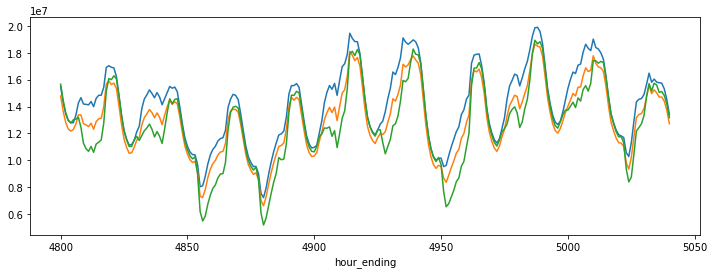

In [12]:
fig,ax = plt.subplots(figsize=[12,4])
start=200 * 24
dur = 10 * 24
end = start+dur
ax=gross_net_df.loc[start:end,'net_load'].plot()
gross_net_df2.loc[start:end,'net_load'].plot(ax=ax)
gross_net_df3.loc[start:end, 'net_load'].plot(ax=ax)

<AxesSubplot:>

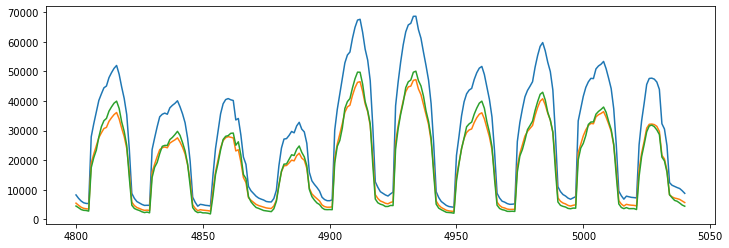

In [13]:
fig,ax = plt.subplots(figsize=[12,4])
ax=shiftable_load_df.loc[start:end,('com','cooling',200.0)].plot()
shiftable_load_df2.loc[start:end,('com','cooling',200.0)].plot(ax=ax)
shiftable_load_df3.loc[start:end,('com','cooling',200.0)].plot(ax=ax)

<AxesSubplot:>

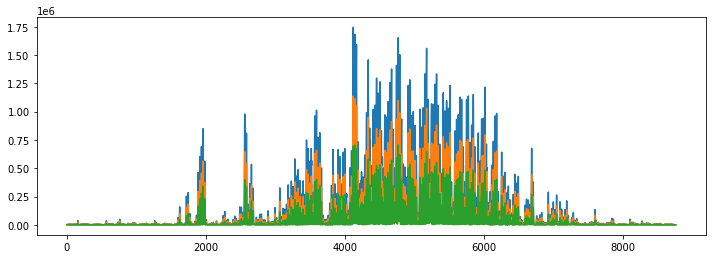

In [14]:
fig,ax = plt.subplots(figsize=[12,4])
ax=sheddable_load_df['com','cooling',200.0].plot()
sheddable_load_df2['com','cooling',200.0].plot(ax=ax)
sheddable_load_df3['com','cooling',200.0].plot(ax=ax)

<AxesSubplot:>

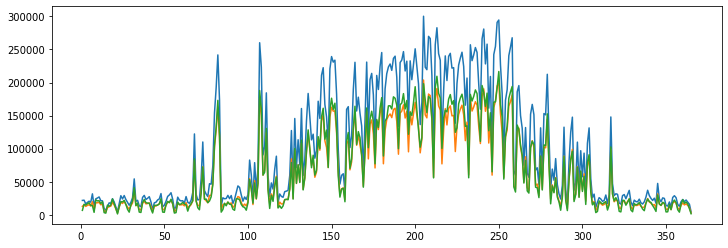

In [15]:
fig,ax = plt.subplots(figsize=[12,4])
ax=daily_shift_cap_df['com','cooling',200.0].plot()
daily_shift_cap_df2['com','cooling',200.0].plot(ax=ax)
daily_shift_cap_df3['com','cooling',200.0].plot(ax=ax)

BaseDemand_Baseline_2012AMY
    2020


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
com heating 400.0


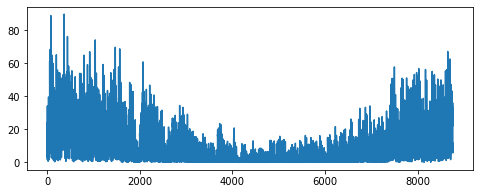

com water_heating 400.0


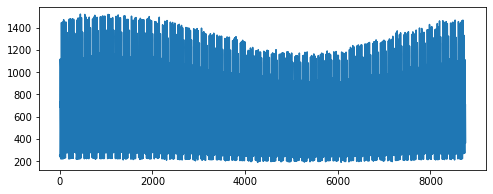

Extracting Shift:
    2025


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2030


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2035


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2040


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
BaseDemand_ControlsOnly_2012AMY
    2020


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2025


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2030


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2035


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2040


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
BaseDemand_EnvelopeOnly_2012AMY
    2020


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2025


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2030


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2035


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2040


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
BaseDemand_EnvelopePlusControlsPlusEquipment_2012AMY
    2020


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2025


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2030


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2035


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2040


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
BaseDemand_EnvelopePlusControls_2012AMY
    2020


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2025


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2030


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2035


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2040


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
BaseDemand_EquipmentOnly_2012AMY
    2020


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2025


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2030


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2035


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:
    2040


/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Extracting Shed:
Extracting Shift:


In [16]:
for ds in models.DemandScenario.select():
    print(ds.name)
    for y in[2020, 2025, 2030, 2035, 2040]:
        print('    {y}'.format(y=y))
        fulloutdir = os.path.join(outdir,ds.name,str(y))
        os.makedirs(fulloutdir, exist_ok=True)
        (sheddable_load_df, max_capacity_shed, 
        shiftable_load_df, max_capacity_shift, daily_shift_cap_df, 
        shift_windows, max_take_df, gross_net)=get_8760_outputs(ds, tou, rs, ts, y, 
                                                     diagnostics=('Baseline'in ds.name) & (y==2020), 
                                                     outdir=fulloutdir)

In [17]:
max_take_df.tail()

sector                    com                                             \
end_use               cooling                                              
procurement_price       50.0          100.0         150.0          200.0   
8756               613.817643  25452.394591  94747.959043  150771.115608   
8757               616.720288  25454.589875  94752.079547  150777.380165   
8758               620.457076  25461.320957  94761.199074  150784.135823   
8759               620.507682  25462.678745  94774.388488  150796.581586   
8760               621.245635  25464.614650  94780.884661  150804.940462   

sector                                                                        \
end_use                                                              heating   
procurement_price          300.0          400.0          500.0         50.0    
8756               303021.479760  459227.098902  859030.296288  72003.570787   
8757               303030.434813  459239.624722  859042.883983  72271.165841   
8758               303040.189446  459252.431588  859058.958895  70297.603812   
8759               303055.731950  459265.833519  859060.080724  71788.372497   
8760               303065.787225  459275.122085  859064.283345  74430.532862   

sector                                         ...       res        \
end_use                                        ... pool_pump         
procurement_price         100.0         150.0  ...     300.0 400.0   
8756               1.438953e+06  1.890647e+06  ...         0     0   
8757               1.438339e+06  1.891971e+06  ...         0     0   
8758               1.439525e+06  1.901893e+06  ...         0     0   
8759               1.443401e+06  1.917056e+06  ...         0     0   
8760               1.461457e+06  1.946755e+06  ...         0     0   

sector                                                                        \
end_use                        water_heating                                   
procurement_price        500.0         50.0  100.0 150.0 200.0         300.0   
8756               2339.669711             0     0     0     0  35475.077916   
8757               2583.488447             0     0     0     0  43659.022793   
8758               2764.095785             0     0     0     0  53380.192383   
8759               3177.441320             0     0     0     0  57256.894887   
8760               3177.441320             0     0     0     0  72255.492827   

sector                                           
end_use                                          
procurement_price          400.0          500.0  
8756               101115.906379  110832.044850  
8757               125989.322785  136890.111730  
8758               150466.054992  162017.588631  
8759               159527.409510  174540.693440  
8760               209657.754120  227863.431353  

[5 rows x 63 columns]

<AxesSubplot:>

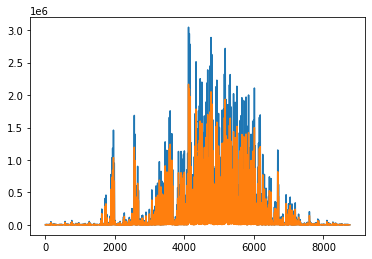

In [18]:
fulloutdir = os.path.join(outdir, 'BaseDemand_Baseline_2012AMY', '2040')
sheddable_load2 = pd.read_csv(os.path.join(fulloutdir,'../2020/sheddable_load.csv'), header=[0,1,2])
sheddable_load = pd.read_csv(os.path.join(fulloutdir,'sheddable_load.csv'), header=[0,1,2])
ax=sheddable_load['com','cooling','300.0'].plot()
sheddable_load2['com','cooling','300.0'].plot(ax=ax)

<AxesSubplot:>

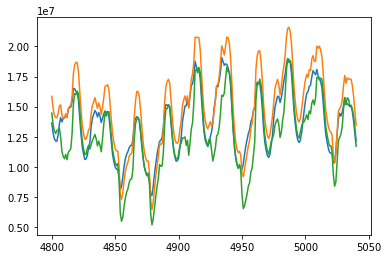

In [19]:
gn2 = pd.read_csv(os.path.join(fulloutdir, 'gross_net_load.csv'))
gn = pd.read_csv(os.path.join(fulloutdir, '../2020/gross_net_load.csv'))
gn3 = pd.read_csv(os.path.join(fulloutdir,'../../BaseDemand_EquipmentOnly_2012AMY/2040/gross_net_load.csv'))
ax=gn.loc[200*24:210*24,'net_load'].plot()
gn2.loc[200*24:210*24, 'net_load'].plot(ax=ax)
gn3.loc[200*24:210*24, 'net_load'].plot(ax=ax)

<AxesSubplot:>

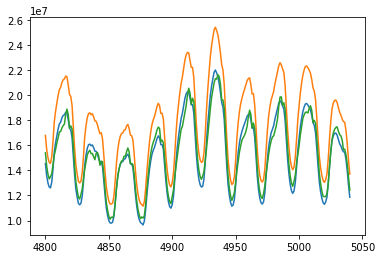

In [20]:
ax=gn.loc[200*24:210*24,'gross_load'].plot()
gn2.loc[200*24:210*24, 'gross_load'].plot(ax=ax)
gn3.loc[200*24:210*24, 'gross_load'].plot(ax=ax)

In [21]:
gn.head()

hour_ending  gross_load      net_load
0          1.0  11292000.0  1.003618e+07
1          2.0  10645000.0  9.428321e+06
2          3.0  10179000.0  8.964310e+06
3          4.0  10022000.0  8.818447e+06
4          5.0   9960000.0  8.802458e+06

In [22]:
fulloutdir

'/mnt/sdb/bgerke_cache/bto_ee_dr_cache/reeds_outputs/all_eligible_upgrades_20210827/NENG/BaseDemand_Baseline_2012AMY/2040'

In [23]:
max_capacity_shift

sector                    com                                          \
end_use               cooling                                           
procurement_price       50.0         100.0        150.0         200.0   
capacity           105.941127  2731.555058  9406.557008  19344.677082   

sector                                                                     \
end_use                                                           heating   
procurement_price         300.0         400.0         500.0         50.0    
capacity           43926.686873  62583.258078  82753.780928  14434.737675   

sector                                           ...       res        \
end_use                                          ... pool_pump         
procurement_price          100.0          150.0  ...     300.0 400.0   
capacity           282394.851536  417757.391433  ...       0.0   0.0   

sector                                                                        \
end_use                        water_heating                                   
procurement_price        500.0         50.0  100.0 150.0 200.0         300.0   
capacity           2528.091179           0.0   0.0   0.0   0.0  84249.262178   

sector                                           
end_use                                          
procurement_price          400.0          500.0  
capacity           246784.262198  266760.385562  

[1 rows x 63 columns]

In [24]:
shift_windows

sector  end_use        procurement_price
com     cooling        50.0                 7.925457
                       100.0                7.749650
                       150.0                7.793013
                       200.0                7.856994
                       300.0                7.738107
                                              ...   
res     water_heating  150.0                0.000000
                       200.0                0.000000
                       300.0                4.000000
                       400.0                4.000000
                       500.0                4.000000
Length: 63, dtype: float64

In [25]:
models.database.close()

True

In [28]:
np.repeat(np.array([0.2,0.2,0.2,0.2,0.2,0.2,
                   0.2,0.2,0.2,0.2,0.2,0.2,
                   0.2,0.2,0.2,0.2,0.2,0.45,
                   0.45,0.45,0.45,0.2,0.2,0.2,]),365)[0]

array([0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2])